In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Calculating the SSIM score keeping threshold = 0.999
# self coded from scratch

In [2]:
import numpy as np
import cv2

def calculate_ssim(image1, image2, window_size=11, K1=0.01, K2=0.03, L=255):
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions.")

    C1 = (K1 * L) ** 2
    C2 = (K2 * L) ** 2

    def gaussian_kernel(size, sigma=1.5):
        ax = np.arange(-(size // 2), size // 2 + 1, 1)
        xx, yy = np.meshgrid(ax, ax)
        kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
        return kernel / np.sum(kernel)

    kernel = gaussian_kernel(window_size)

    mu1 = convolve(image1, kernel)
    mu2 = convolve(image2, kernel)

    sigma1_sq = convolve(image1 ** 2, kernel) - mu1 ** 2
    sigma2_sq = convolve(image2 ** 2, kernel) - mu2 ** 2
    sigma12 = convolve(image1 * image2, kernel) - mu1 * mu2

    numerator = (2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)
    denominator = (mu1 ** 2 + mu2 ** 2 + C1) * (sigma1_sq + sigma2_sq + C2)
    ssim_map = numerator / denominator

    return np.mean(ssim_map)

def convolve(image, kernel):
    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape

    pad_h = kernel_height // 2
    pad_w = kernel_width // 2

    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')

    convolved_image = np.zeros_like(image, dtype=np.float64)

    for i in range(image_height):
        for j in range(image_width):
            region = padded_image[i:i + kernel_height, j:j + kernel_width]
            convolved_image[i, j] = np.sum(region * kernel)

    return convolved_image

if __name__ == "__main__":

    img1_path = "/content/shirt1.jpg"
    img2_path = "/content/shirt2.jpg"

    threshold = 0.999

    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    if img1 is None or img2 is None:
        print(f"Error loading images: {img1_path} or {img2_path}")
    else:
        img1 = cv2.resize(img1, (224, 224))
        img2 = cv2.resize(img2, (224, 224))
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

        ssim_value = calculate_ssim(img1, img2)
        prediction = 1 if ssim_value >= threshold else 0

        print(f"SSIM between the images: {ssim_value}")
        print(f"Prediction: {'Similar' if prediction == 1 else 'Different'}")


SSIM between the images: 0.976658487165018
Prediction: Different


# Calculating MS_SIM score self_coded from scratch


In [3]:
import numpy as np
import cv2

def calculate_ms_ssim(image1, image2, window_size=11, K1=0.01, K2=0.03, L=255, levels=5):

    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions.")

    C1 = (K1 * L) ** 2
    C2 = (K2 * L) ** 2

    def gaussian_kernel(size, sigma=1.5):
        ax = np.arange(-(size // 2), size // 2 + 1, 1)
        xx, yy = np.meshgrid(ax, ax)
        kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
        return kernel / np.sum(kernel)

    kernel = gaussian_kernel(window_size)

    def ssim_at_scale(img1, img2, kernel, C1, C2):
        mu1 = convolve(img1, kernel)
        mu2 = convolve(img2, kernel)

        sigma1_sq = convolve(img1 ** 2, kernel) - mu1 ** 2
        sigma2_sq = convolve(img2 ** 2, kernel) - mu2 ** 2
        sigma12 = convolve(img1 * img2, kernel) - mu1 * mu2

        numerator = (2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)
        denominator = (mu1 ** 2 + mu2 ** 2 + C1) * (sigma1_sq + sigma2_sq + C2)
        ssim_map = numerator / denominator

        return np.mean(ssim_map)

    ms_ssim_value = 1
    for i in range(levels):
        ssim_value = ssim_at_scale(image1, image2, kernel, C1, C2)
        ms_ssim_value *= ssim_value

        image1 = cv2.resize(image1, (image1.shape[1] // 2, image1.shape[0] // 2))
        image2 = cv2.resize(image2, (image2.shape[1] // 2, image2.shape[0] // 2))

    ms_ssim_value = ms_ssim_value ** (1 / levels)

    return ms_ssim_value

def convolve(image, kernel):
    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape

    pad_h = kernel_height // 2
    pad_w = kernel_width // 2

    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')

    convolved_image = np.zeros_like(image, dtype=np.float64)

    for i in range(image_height):
        for j in range(image_width):
            region = padded_image[i:i + kernel_height, j:j + kernel_width]
            convolved_image[i, j] = np.sum(region * kernel)

    return convolved_image

if __name__ == "__main__":
    image_pairs = []
    image_pairs.append(("/content/shirt1.jpg", "/content/shirt2.jpg"))

    ground_truth = [1] * 203 + [0]  # 1: similar, 0: different

    threshold = 0.90
    predictions = []

    for img1_path, img2_path in image_pairs:
        img1 = cv2.imread(img1_path)
        img2 = cv2.imread(img2_path)

        if img1 is None or img2 is None:
            print(f"Error loading images: {img1_path} or {img2_path}")
            predictions.append(0)
            continue

        img1 = cv2.resize(img1, (256, 256))
        img2 = cv2.resize(img2, (256, 256))
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

        ms_ssim_value = calculate_ms_ssim(img1, img2)
        prediction = 1 if ms_ssim_value >= threshold else 0
        predictions.append(prediction)

        print(f"MS-SSIM between {img1_path} and {img2_path}: {ms_ssim_value} (Prediction: {'Similar' if prediction == 1 else 'Different'})")

    true_positive = sum(1 for p, t in zip(predictions, ground_truth) if p == t == 1)
    true_negative = sum(1 for p, t in zip(predictions, ground_truth) if p == t == 0)
    false_positive = sum(1 for p, t in zip(predictions, ground_truth) if p == 1 and t == 0)
    false_negative = sum(1 for p, t in zip(predictions, ground_truth) if p == 0 and t == 1)

    accuracy = (true_positive + true_negative) / len(ground_truth)
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")


MS-SSIM between /content/shirt1.jpg and /content/shirt2.jpg: 0.9881687443072581 (Prediction: Similar)
Accuracy: 0.00
Precision: 1.00
Recall: 1.00


# Using SSIM by directly importing SSIM from structural_similarity

In [4]:
from skimage.metrics import structural_similarity as ssim
import cv2

img1 = cv2.imread('/content/image_not_dup11.jpg')
img2 = cv2.imread('/content/image_not_dup12.jpg')

img1 = cv2.resize(img1, (224, 224))
img2 = cv2.resize(img2, (224, 224))

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

ssim_score, _ = ssim(img1_gray, img2_gray, full=True)

threshold = 0.99
prediction = 1 if ssim_score >= threshold else 0

print(f"SSIM between the images: {ssim_score} (Prediction: {'Similar' if prediction == 1 else 'Different'})")


SSIM between the images: 0.988676112105135 (Prediction: Different)


# Image Similarity using VGGNET

In [5]:
import numpy as np
from numpy import linalg as LA
import torch
import torch.nn as nn
import numpy as np
from torchvision import models, transforms
from PIL import Image
import os
import h5py
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance

Start feature extraction...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 52.1MB/s]


Extracting features from image: /content/shirt1.jpg
Extracting features from image: /content/shirt2.jpg
Writing feature extraction results to CNNFeatures.h5
Feature extraction and saving completed.
Top 2 matches with similarity scores:
1. Image: shirt1.jpg, Score: 1.0000
2. Image: shirt2.jpg, Score: 0.9379


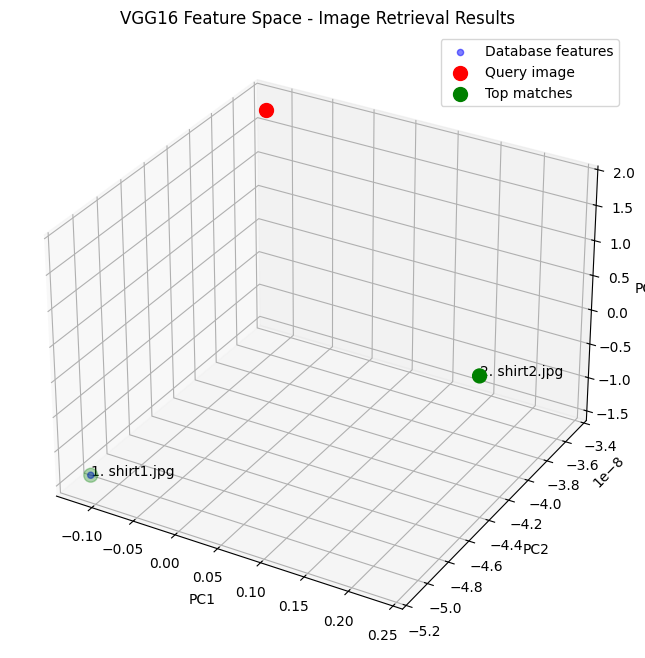

In [6]:
class VGGNet:
    def __init__(self):
        self.input_shape = (224, 224, 3)
        self.model = models.vgg16(pretrained=True).features
        self.model.eval()

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def extract_feat(self, img_path):
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img).unsqueeze(0)

        with torch.no_grad():
            feat = self.model(img)

        feat = feat.view(feat.size(0), -1)
        norm_feat = feat / feat.norm()
        return norm_feat.numpy().flatten()



images_path1 = "/content/shirt1.jpg"
images_path2 = "/content/shirt2.jpg"

# images_path = "/content/drive/MyDrive/human_images/images_humans"
# img_list = [os.path.join(images_path, f) for f in os.listdir(images_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
img_list = [images_path1, images_path2]
print("Start feature extraction...")

model = VGGNet()

feats = []
names = []

for im in img_list:
    print(f"Extracting features from image: {im}")
    X = model.extract_feat(im)
    feats.append(X)
    names.append(os.path.basename(im))

feats = np.array(feats)

output = "CNNFeatures.h5"
print(f"Writing feature extraction results to {output}")

with h5py.File(output, 'w') as h5f:
    h5f.create_dataset('dataset_1', data=feats)
    h5f.create_dataset('dataset_2', data=np.array(names, dtype='S'))

print("Feature extraction and saving completed.")


# FEATURE EXTRACTION

def plot_feature_space(features, query_feat, top_matches, imgNames, title="Feature Space Visualization"):
    """Visualize high-dimensional features in 3D using PCA"""
    pca = PCA(n_components=3)
    all_features = np.vstack([features, query_feat.reshape(1, -1)])
    features_3d = pca.fit_transform(all_features)

    db_features_3d = features_3d[:-1]
    query_feature_3d = features_3d[-1]

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(db_features_3d[:, 0], db_features_3d[:, 1], db_features_3d[:, 2],
              c='blue', alpha=0.5, label='Database features')

    ax.scatter(query_feature_3d[0], query_feature_3d[1], query_feature_3d[2],
              c='red', s=100, label='Query image')

    matches_3d = db_features_3d[top_matches]
    ax.scatter(matches_3d[:, 0], matches_3d[:, 1], matches_3d[:, 2],
              c='green', s=100, label='Top matches')

    for i, match_idx in enumerate(top_matches):
        img_name = imgNames[match_idx].decode('utf-8') if isinstance(imgNames[match_idx], bytes) else imgNames[match_idx]
        ax.text(matches_3d[i, 0], matches_3d[i, 1], matches_3d[i, 2], f'{i+1}. {img_name}')

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title(title)
    ax.legend()
    plt.show()

with h5py.File("CNNFeatures.h5", 'r') as h5f:
    feats = h5f['dataset_1'][:]
    imgNames = h5f['dataset_2'][:]

queryImg = "/content/shirt1.jpg"
model = VGGNet()
query_feat = model.extract_feat(queryImg)

scores = []
for i in range(feats.shape[0]):
    score = 1 - distance.cosine(query_feat, feats[i])
    scores.append(score)
scores = np.array(scores)

rank_ID = np.argsort(scores)[::-1]
rank_score = scores[rank_ID]

top_n = 2
top_matches = rank_ID[:top_n]
top_scores = rank_score[:top_n]

print(f"Top {top_n} matches with similarity scores:")
for i, (image_id, score) in enumerate(zip(top_matches, top_scores)):
    image_name = imgNames[image_id].decode('utf-8') if isinstance(imgNames[image_id], bytes) else imgNames[image_id]
    print(f"{i+1}. Image: {image_name}, Score: {score:.4f}")

plot_feature_space(feats, query_feat, top_matches, imgNames, "VGG16 Feature Space - Image Retrieval Results")


# Similarity using HISTOGRAM approach

In [7]:
import cv2
# Load images
image1 = '/content/shirt1.jpg'
image2 = '/content/shirt2.jpg'

image1 = cv2.imread(image1)
image2 = cv2.imread(image2)

image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

hist_img1 = cv2.calcHist([image1], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
hist_img1[255, 255, 255] = 0
cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
hist_img2 = cv2.calcHist([image2], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
hist_img2[255, 255, 255] = 0
cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
metric_val = cv2.compareHist(hist_img1, hist_img2, cv2.HISTCMP_CORREL)
print(f"Similarity Score: ", round(metric_val, 2))

Similarity Score:  0.64


## SSIM from scratch code

In [8]:
import math
import numpy as np
import cv2

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

img1 = cv2.imread('/content/image_not_dup11.jpg')
img2 = cv2.imread('/content/image_not_dup12.jpg')

img1 = cv2.resize(img1, (224, 224))
img2 = cv2.resize(img2, (224, 224))

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

threshold = 0.99
ssim_score = calculate_ssim(img1_gray, img2_gray)

print(f"SSIM between the images: {ssim_score}")
prediction = 1 if ssim_score >= threshold else 0
print(f"Prediction: {'Similar' if prediction == 1 else 'Different'}")

SSIM between the images: 0.9884940981108292
Prediction: Different


# MS-SSIM from scratch

In [9]:
import numpy as np
import cv2

def ssim(img1, img2):
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = cv2.filter2D(img1 ** 2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2 ** 2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / (
        (mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2)
    )

    return ssim_map.mean()

def calculate_ms_ssim(img1, img2, levels=5):
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2

    if not img1.shape == img2.shape:
        raise ValueError("Input images must have the same dimensions.")

    if img1.ndim == 3:
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    if img2.ndim == 3:
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    ms_ssim_value = 1.0
    weights = [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]

    for i in range(levels):
        ssim_value = ssim(img1, img2)
        ms_ssim_value *= ssim_value ** weights[i]

        img1 = cv2.resize(img1, (img1.shape[1] // 2, img1.shape[0] // 2))
        img2 = cv2.resize(img2, (img2.shape[1] // 2, img2.shape[0] // 2))

    return ms_ssim_value

# Load the images
image_path1 = '/content/shirt1.jpg'
image_path2 = '/content/shirt2.jpg'

img1 = cv2.imread(image_path1)
img2 = cv2.imread(image_path2)

if img1 is None or img2 is None:
    print(f"Error: One or both image paths are incorrect: {image_path1}, {image_path2}")
else:
    img1 = cv2.resize(img1, (224, 224))
    img2 = cv2.resize(img2, (224, 224))

    threshold = 0.9
    ms_ssim_score = calculate_ms_ssim(img1, img2)

    print(f"MS-SSIM between the images: {ms_ssim_score}")
    prediction = 1 if ms_ssim_score >= threshold else 0
    print(f"Prediction: {'Similar' if prediction == 1 else 'Different'}")


MS-SSIM between the images: 0.7987758966942411
Prediction: Different


# MS-SSIM from pytorch

In [10]:
!pip install pytorch-msssim
import torch
import cv2
import pytorch_msssim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

img1 = cv2.imread('/content/shirt1.jpg')
img2 = cv2.imread('/content/shirt2.jpg')

img1 = cv2.resize(img1, (256, 256))
img2 = cv2.resize(img2, (256, 256))

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img1_tensor = torch.from_numpy(img1).float().unsqueeze(0).permute(0, 3, 1, 2) / 255.0
img2_tensor = torch.from_numpy(img2).float().unsqueeze(0).permute(0, 3, 1, 2) / 255.0

img1_tensor = img1_tensor.to(device)
img2_tensor = img2_tensor.to(device)

ssim_value = pytorch_msssim.ssim(img1_tensor, img2_tensor, data_range=1.0, size_average=True)

print(f"SSIM between the images: {ssim_value.item()}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# using MS-SIM from Torch.metrics

In [11]:
# from torch import rand
# from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure
# preds = torch.rand([3, 3, 256, 256])
# target = preds * 0.75
# ms_ssim = MultiScaleStructuralSimilarityIndexMeasure(data_range=1.0)
# ms_ssim(preds, target)

!pip install torchmetrics

import torch
import cv2
from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure

img1 = cv2.imread('/content/shirt1.jpg')
img2 = cv2.imread('/content/shirt2.jpg')

img1 = cv2.resize(img1, (256, 256))
img2 = cv2.resize(img2, (256, 256))

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img1_tensor = torch.from_numpy(img1).float().unsqueeze(0).permute(0, 3, 1, 2) / 255.0
img2_tensor = torch.from_numpy(img2).float().unsqueeze(0).permute(0, 3, 1, 2) / 255.0

ms_ssim = MultiScaleStructuralSimilarityIndexMeasure(data_range=1.0)

ms_ssim_score = ms_ssim(img1_tensor, img2_tensor)

print(f"MS-SSIM between the images: {ms_ssim_score.item()}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 15.0 MB/s eta 0:00:00
MS-SSIM between the images: 0.7919092178344727


# Hybrid score combining SSIM and CNN approach

In [13]:
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
from torchvision import models
from skimage.metrics import structural_similarity as ssim

# Load a pre-trained CNN model
model = models.resnet18(pretrained=True)
model.eval()

# Image preprocessing for CNN feature extraction
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to load and preprocess the image for CNN
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = transform(img).unsqueeze(0)
    return img

def extract_features(img_tensor):
    with torch.no_grad():
        features = model(img_tensor)
    return features.squeeze().cpu().numpy()

def cosine_similarity(features1, features2):
    return np.dot(features1, features2) / (np.linalg.norm(features1) * np.linalg.norm(features2))

def calculate_ssim(image1, image2):
    image1 = image1.astype(np.float64)
    image2 = image2.astype(np.float64)
    return ssim(image1, image2, multichannel=True, win_size=7, channel_axis=-1, data_range=255)

def hybrid_similarity(image_path1, image_path2, alpha=0.5, beta=0.5):
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)

    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    img1_resized = cv2.resize(img1_rgb, (224, 224))
    img2_resized = cv2.resize(img2_rgb, (224, 224))

    img_tensor1 = load_image(image_path1)
    img_tensor2 = load_image(image_path2)

    features1 = extract_features(img_tensor1)
    features2 = extract_features(img_tensor2)

    cnn_similarity = cosine_similarity(features1, features2)

    ssim_score = calculate_ssim(img1_resized, img2_resized)

    hybrid_score = alpha * cnn_similarity + beta * ssim_score

    return hybrid_score

image_path1 = '/content/shirt1.jpg'
image_path2 = '/content/shirt2.jpg'

similarity_score = hybrid_similarity(image_path1, image_path2, alpha=0.5, beta=0.5)
print(f"Hybrid Similarity Score: {similarity_score}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.7MB/s]


Hybrid Similarity Score: 0.7784108709822233
